# Exploratory Analysis on IoT-LAB


We start importing useful libraries.

In [384]:
from matplotlib import pyplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

We parse the informations about the network extracting the list of nodes, the IPs and the rank of each node in the RPL istance.

In [446]:
# Read the ip of each node
ips = pd.read_csv('./traces/out-2019-01JAN-28-01.cap', 
                        sep=';|addr:|/',
                        na_filter=True,
                        usecols=[1,3,4], 
                        header=None, 
                        nrows=550,
                        names=['prefix','node_id','addr','ip','scope'],
                        engine='python').dropna()

ips = ips[ips.scope == '64  scope: global'].reset_index(drop=True).drop(['scope'], axis=1)


# Read the rank of each node
rank = pd.read_csv('./traces/out-2019-01JAN-28-01.cap', 
                        sep=';|\t|R: | \| OP: ',
                        na_filter=True,
                        usecols=[1,4], 
                        header=None, 
                        skiprows=550,
                        names=['node_id','rank'],
                        engine='python').dropna()

rank = rank[rank['rank'].apply(lambda x: x.isdigit())].reset_index(drop=True)


# Merge all data
node_ip_and_rank = pd.merge(ips, hop, how='inner').drop_duplicates()
node_ip_and_rank

,node_id,ip,rank
0,m3-97,2001:db8::1711:6b10:65fb:a522,768
2,m3-102,2001:db8::1711:6b10:65f9:5d3a,768
4,m3-166,2001:db8::1711:6b10:65f6:ad06,512
5,m3-142,2001:db8::1711:6b10:65fb:5f36,768
6,m3-129,2001:db8::1711:6b10:65fa:5f06,768
7,m3-145,2001:db8::1711:6b10:65f6:5c06,512
8,m3-161,2001:db8::1711:6b10:65f9:5e06,512
9,m3-121,2001:db8::1711:6b10:65f8:ae16,768
10,m3-126,2001:db8::1711:6b10:65f9:b522,768
11,m3-169,2001:db8::1711:6b10:65fd:aa32,512


Now we parse sequence number and RTT of each ICMP message.

In [530]:
# Read the rank of each node
nodes = pd.read_csv('./traces/out-2019-01JAN-28-01.cap', 
                        sep=';|seq=| hop|time = |ms',
                        na_filter=True,
                        usecols=[1,3,5], 
                        header=None, 
                        skiprows=799,
                        names=['node_id','seq','rtt'],
                        engine='python').dropna().drop_duplicates()

nodes = nodes.sort_values(by=['node_id','seq'], ascending=True, na_position='first')


#
d_nodes = {}   # <node_id, DataFrame containing seq and rtt columns>
for n in nodes.index:
    if nodes['node_id'][n] in d_nodes:
        d_nodes[nodes['node_id'][n]] = d_nodes[nodes['node_id'][n]].append(pd.DataFrame({'seq': [int(nodes['seq'][n])], nodes['node_id'][n]: [nodes['rtt'][n]]}))
    else:
        d_nodes[nodes['node_id'][n]] = pd.DataFrame({'seq': [int(nodes['seq'][n])], nodes['node_id'][n]:[nodes['rtt'][n]]})

    
# 
nodes = pd.DataFrame([seq for seq in range(1,1001)], columns=['seq']).set_index('seq')
for node in d_nodes.keys():
    nodes = nodes.join(d_nodes[node].set_index('seq'))

nodes = nodes[~nodes.index.duplicated(keep='first')]
nodes.head(10)

,m3-102,m3-105,m3-110,m3-113,m3-118,m3-121,m3-126,m3-129,m3-134,m3-137,...,m3-161,m3-166,m3-169,m3-174,m3-179,m3-182,m3-185,m3-188,m3-191,m3-97
seq,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,51.078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.751,NaN,NaN,NaN,NaN,64.229,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.391,NaN,NaN,NaN,44.333,10.714,NaN,NaN,NaN,NaN
4,NaN,81.609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.519,NaN,NaN,13.218,8.164,8.475,NaN,NaN,NaN,NaN
5,NaN,18.591,NaN,80.247,NaN,NaN,NaN,NaN,NaN,NaN,...,8.193,24.857,NaN,9.776,8.166,10.716,NaN,NaN,NaN,NaN
6,NaN,0.609,NaN,17.953,NaN,NaN,NaN,NaN,NaN,NaN,...,9.155,14.781,NaN,8.494,8.812,9.123,NaN,47.369,NaN,NaN
7,NaN,NaN,NaN,27.077,NaN,NaN,NaN,NaN,NaN,68.607,...,10.755,NaN,76.627,10.095,10.726,9.756,NaN,12.954,NaN,NaN
8,NaN,45.111,NaN,28.676,NaN,NaN,NaN,NaN,NaN,61.620,...,9.795,9.422,NaN,9.135,8.807,7.524,NaN,15.180,NaN,NaN
9,NaN,0.607,NaN,23.638,NaN,NaN,NaN,NaN,NaN,42.649,...,11.715,9.429,9.398,9.135,9.766,15.164,NaN,23.344,90.391,NaN


Each node communicates with the root of the DODAG through a certain number of hops. The network was configured in order to have three nodes communicating directly with the root.

In [531]:
rank_to_hops = sorted([int(rank) for rank in list(node_ip_and_rank['rank'].drop_duplicates())])

hops = {}
icmp = [x for x in range(1,len(nodes)+1)]
for node in node_ip_and_rank.index:
    if (rank_to_hops.index(int(node_ip_and_rank['rank'][node]))+1) in hops:
        # The key should be created
        hops[rank_to_hops.index(int(node_ip_and_rank['rank'][node]))+1].append(node_ip_and_rank['node_id'][node])
    else:
        # Just append to the list of nodes
        hops[rank_to_hops.index(int(node_ip_and_rank['rank'][node]))+1] = [node_ip_and_rank['node_id'][node]]


# Contain mean time for each distance from the root
hop_nodes = pd.DataFrame({1: nodes[hops[1]].mean(axis=1), 2: nodes[hops[2]].mean(axis=1),\
                           3: nodes[hops[3]].mean(axis=1)})
hop_nodes.head(10)

,1,2,3
seq,,,
1,51.078000,NaN,NaN
2,37.490000,NaN,NaN
3,22.146000,NaN,NaN
4,16.901000,81.609000,NaN
5,11.969500,49.419000,NaN
6,15.451857,9.281000,NaN
7,20.283143,47.842000,NaN
8,10.533857,45.135667,NaN
9,11.977500,40.934400,NaN


For each node we plot the graph that measures the delay with respect to the number of sequence.

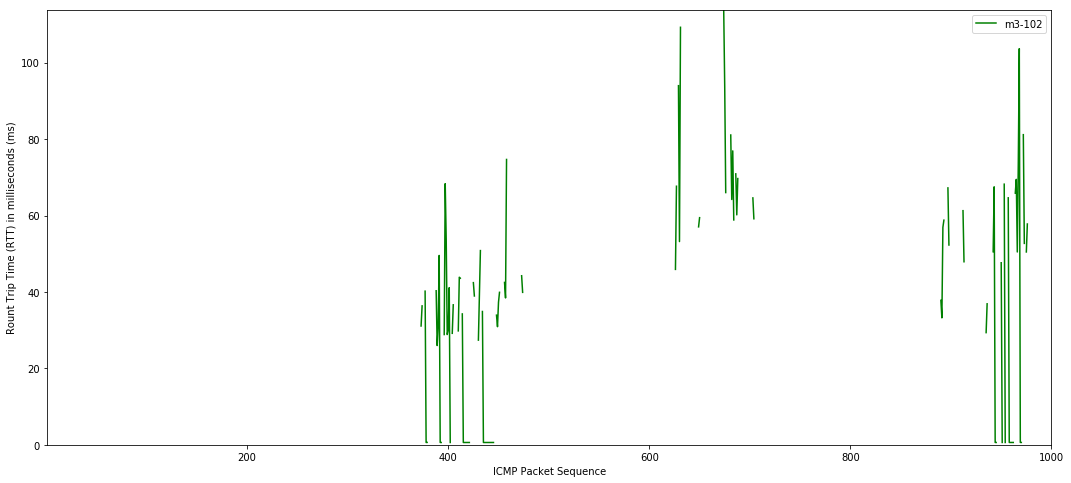

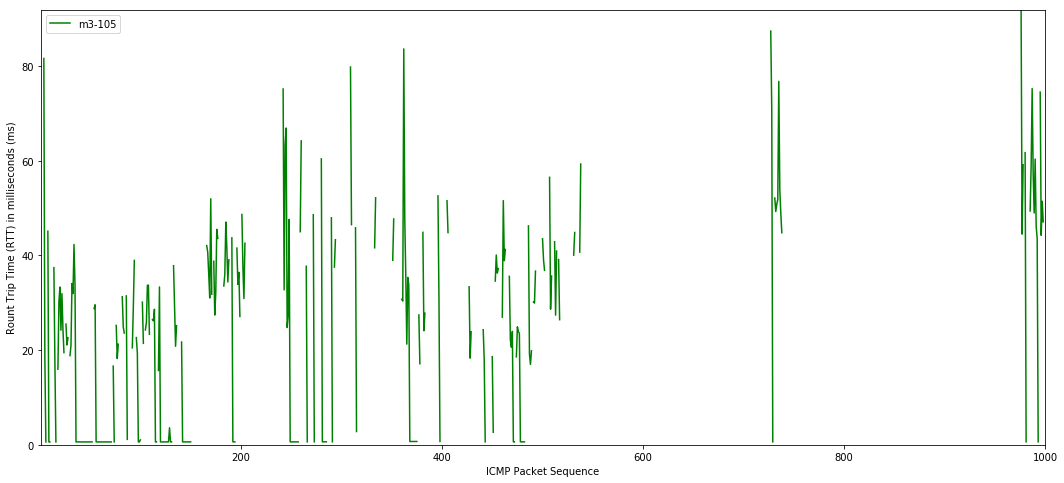

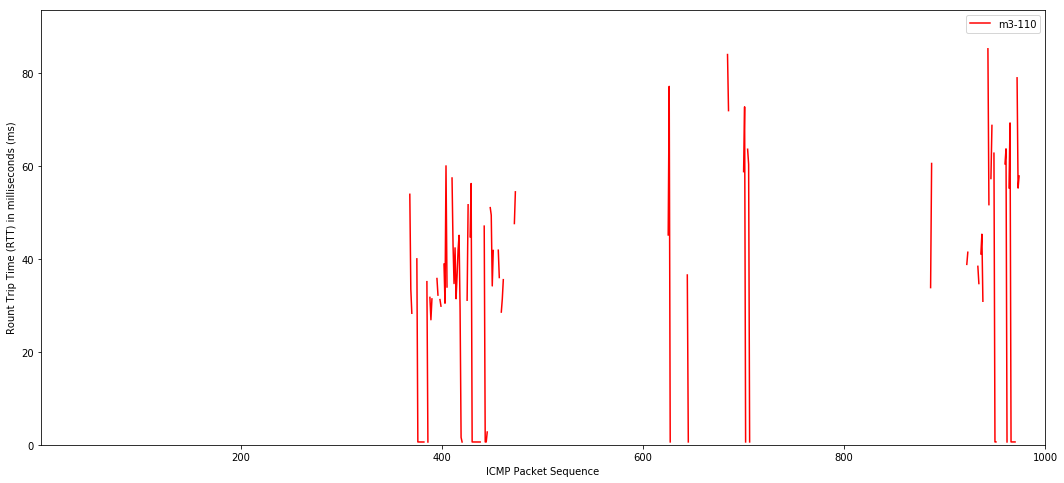

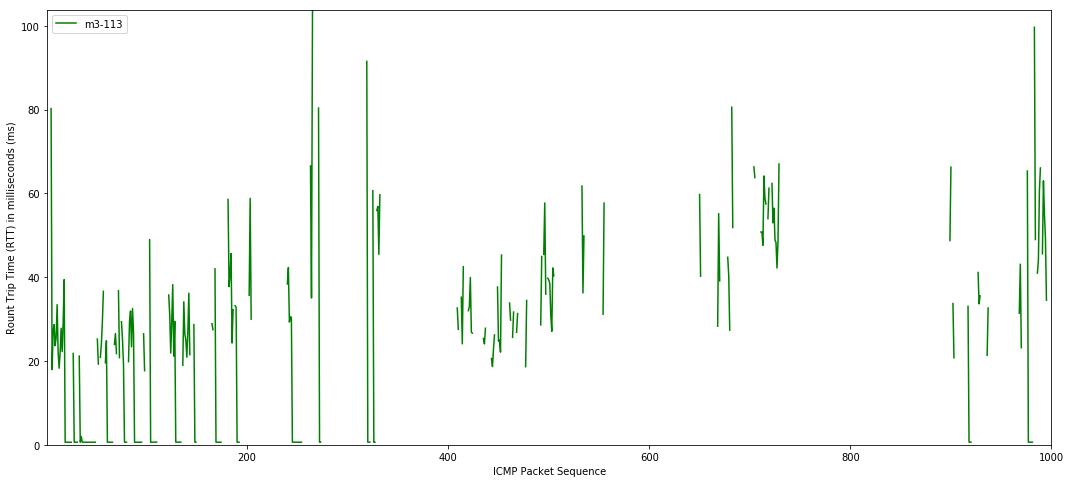

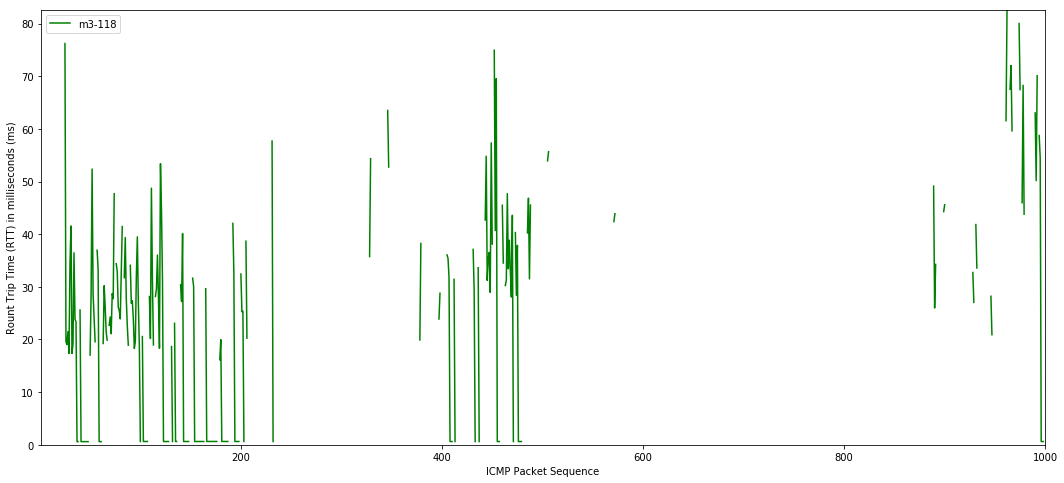

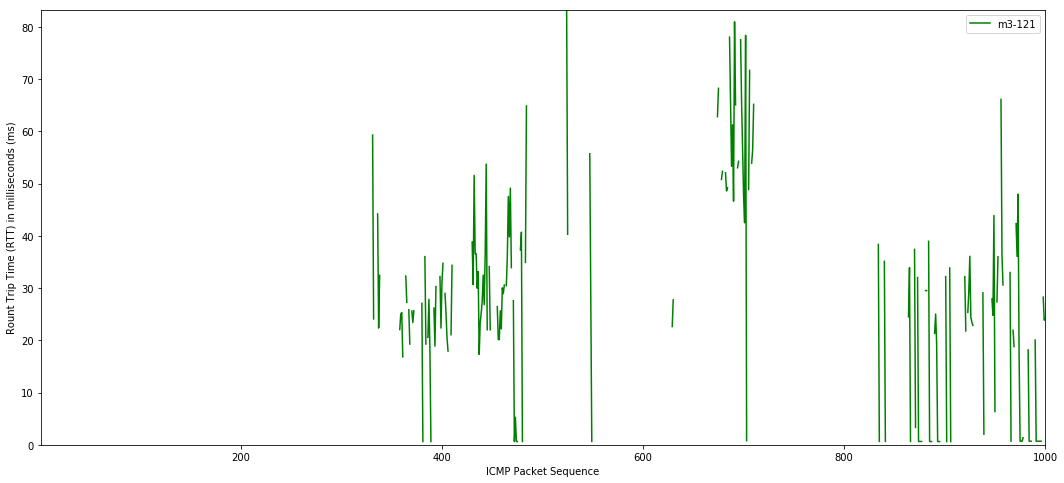

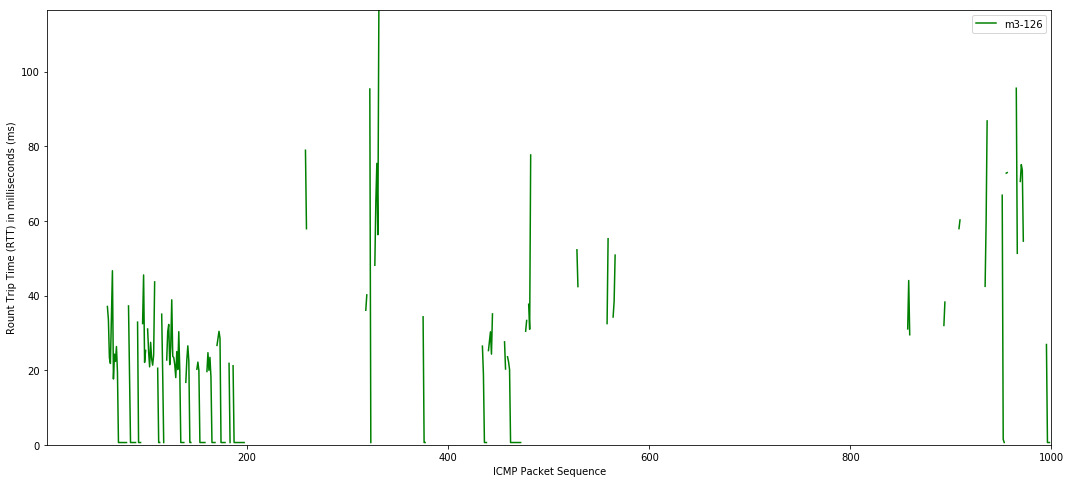

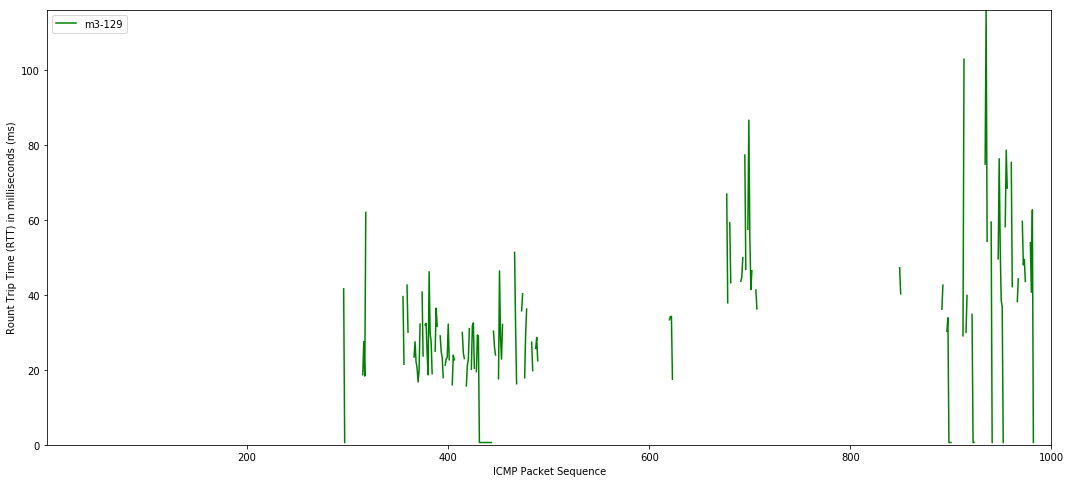

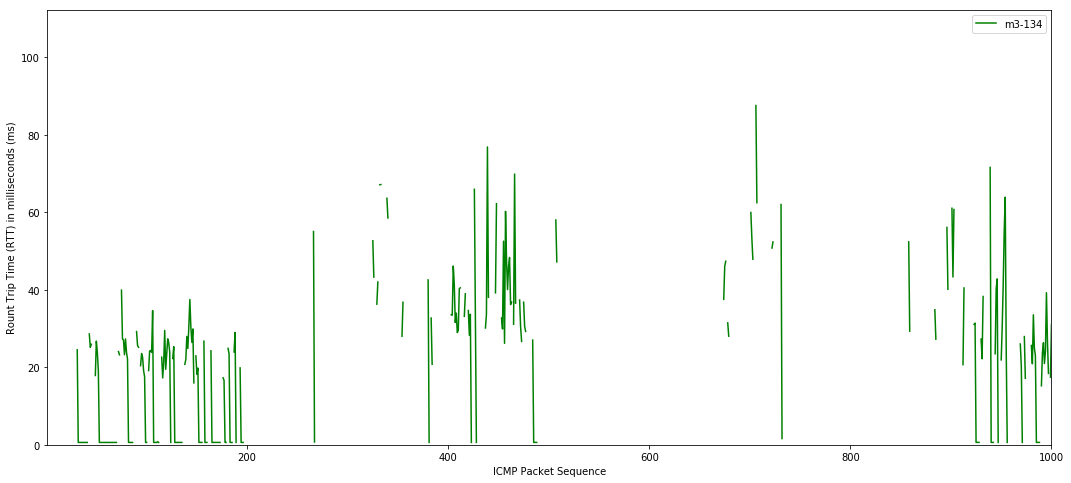

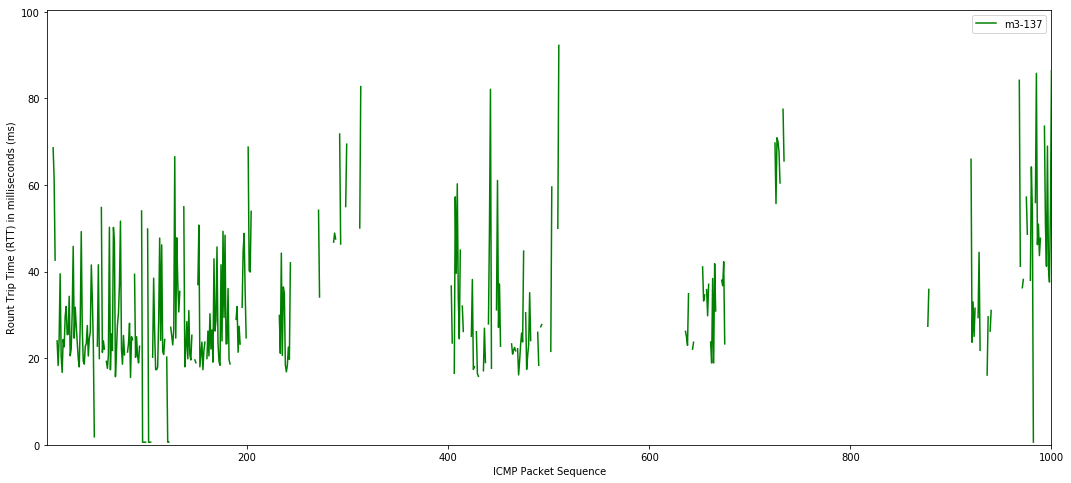

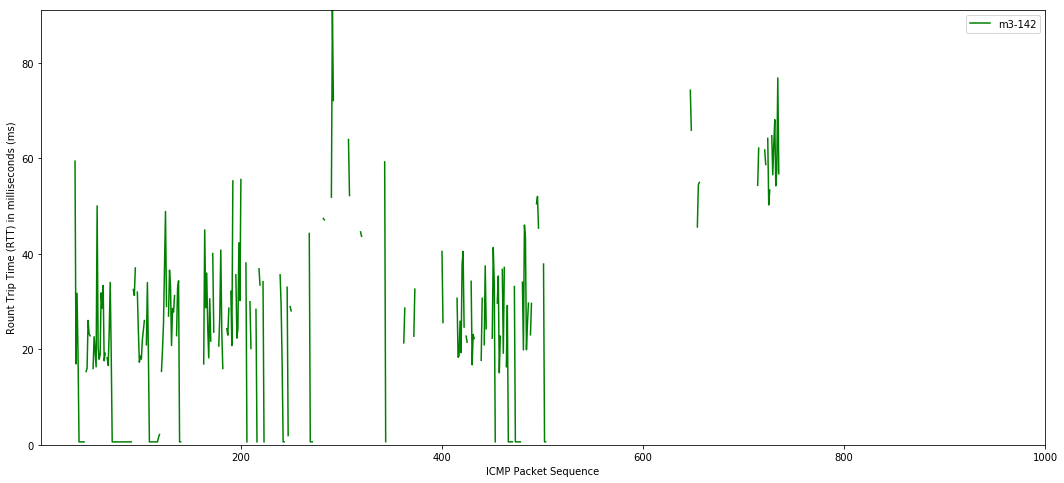

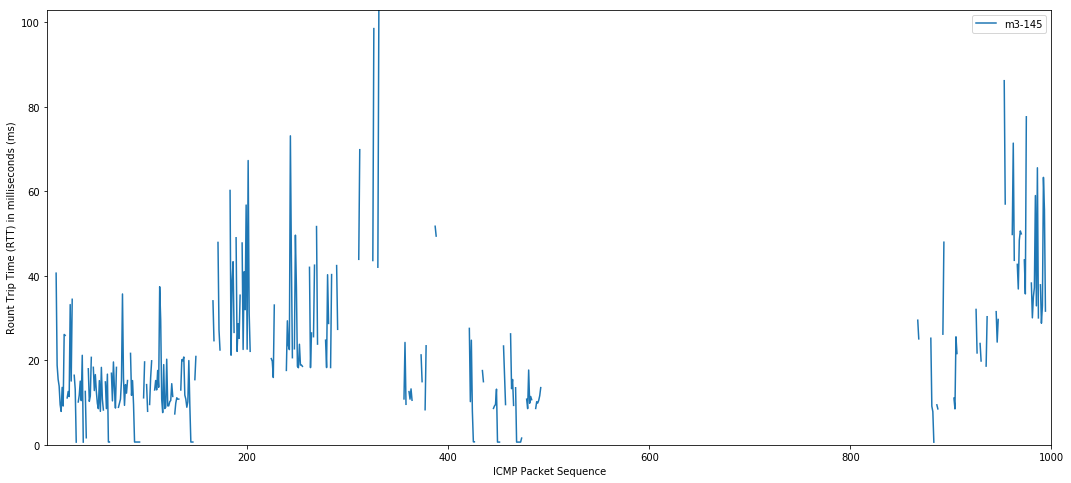

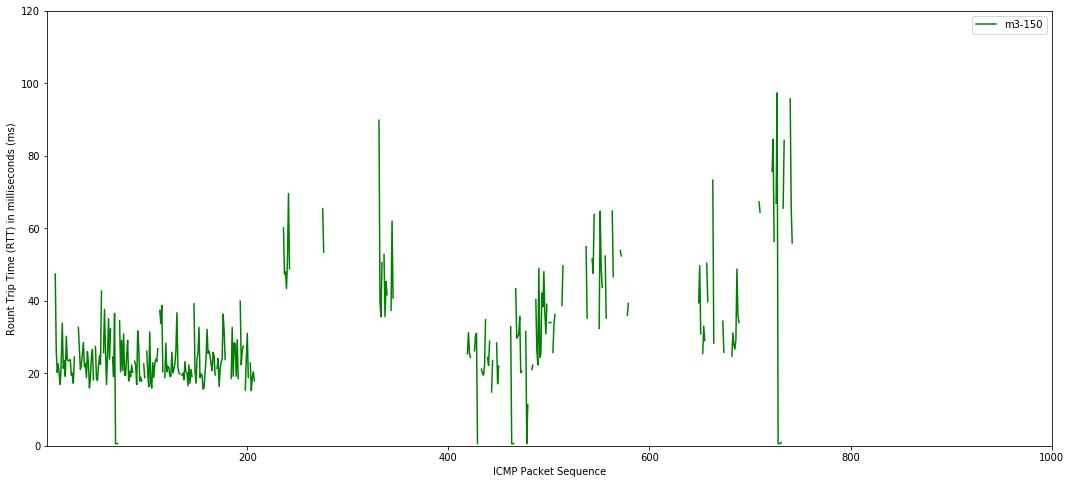

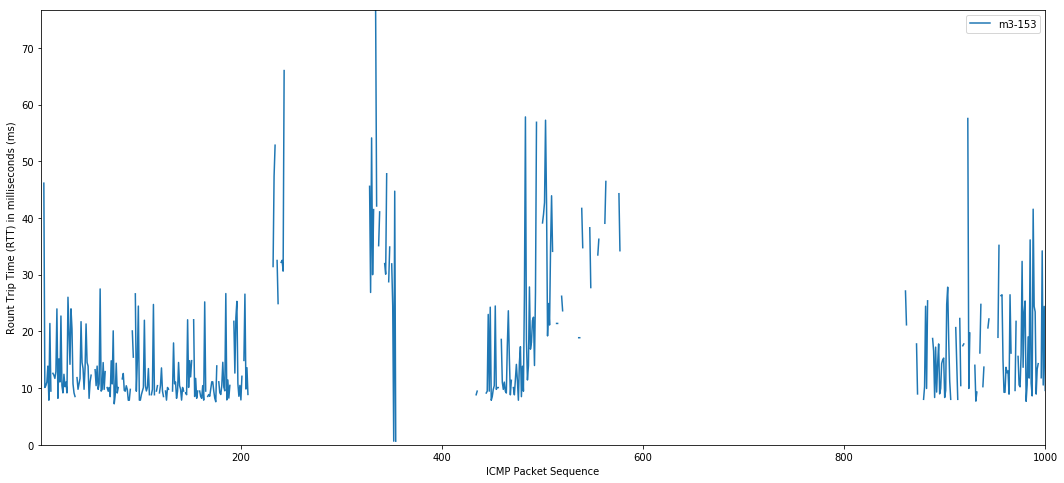

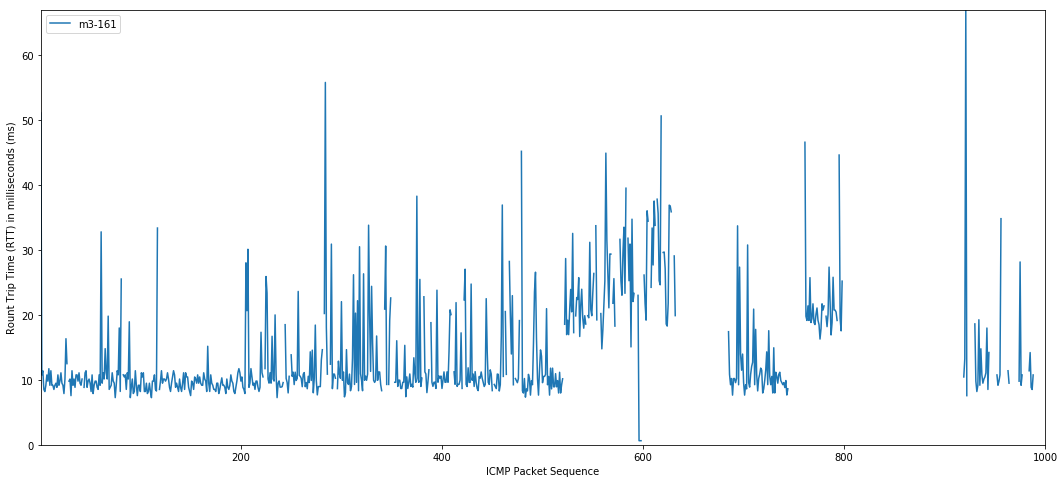

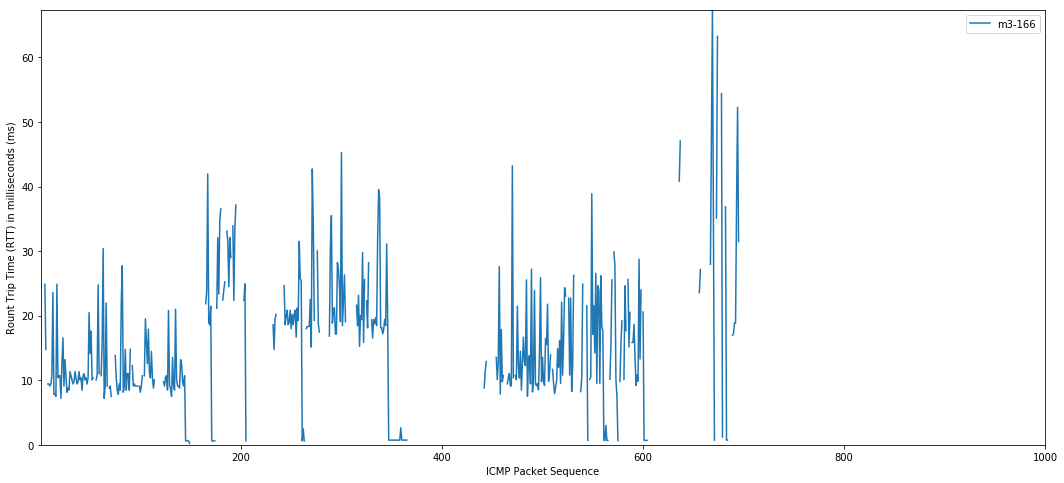

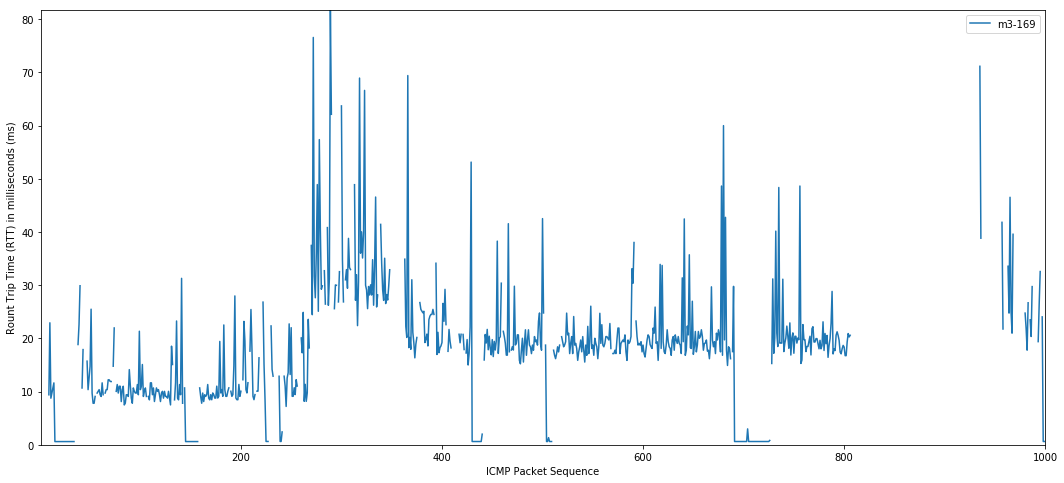

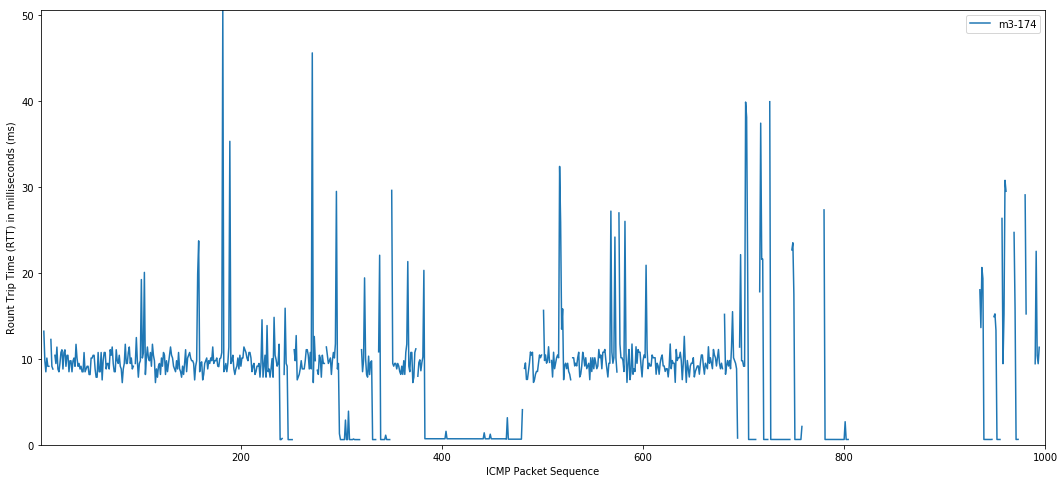

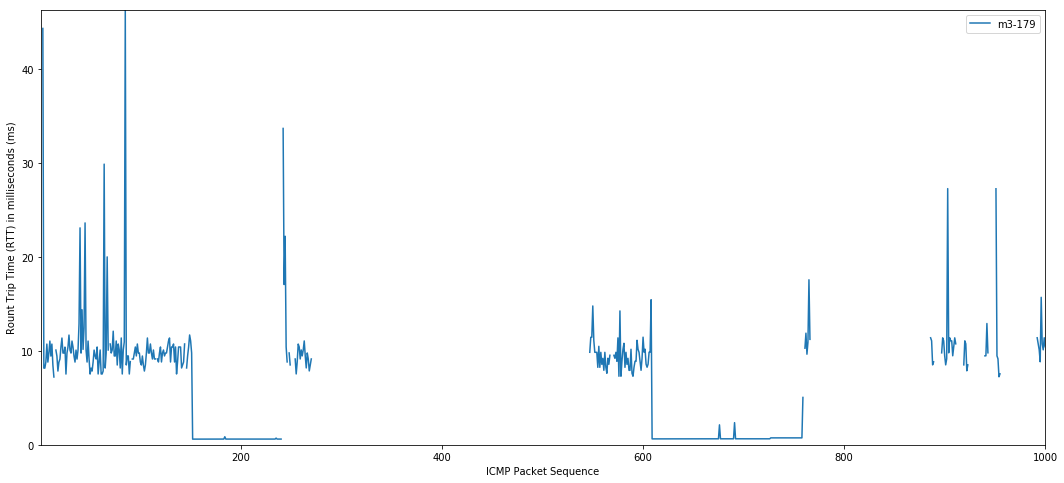

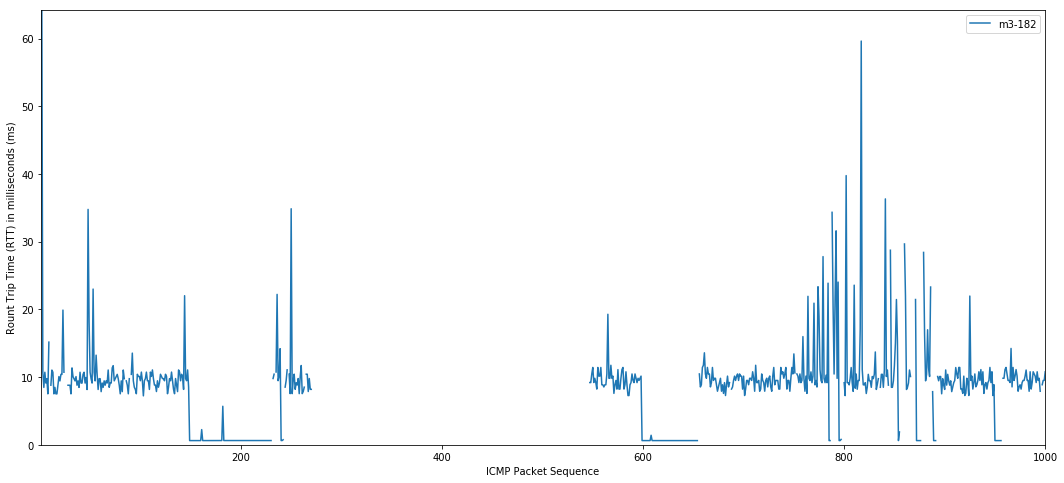

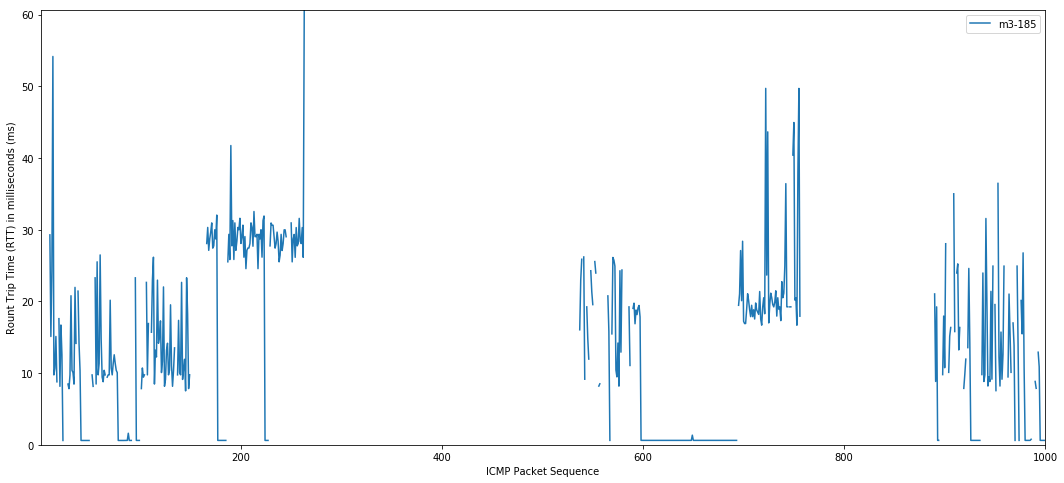

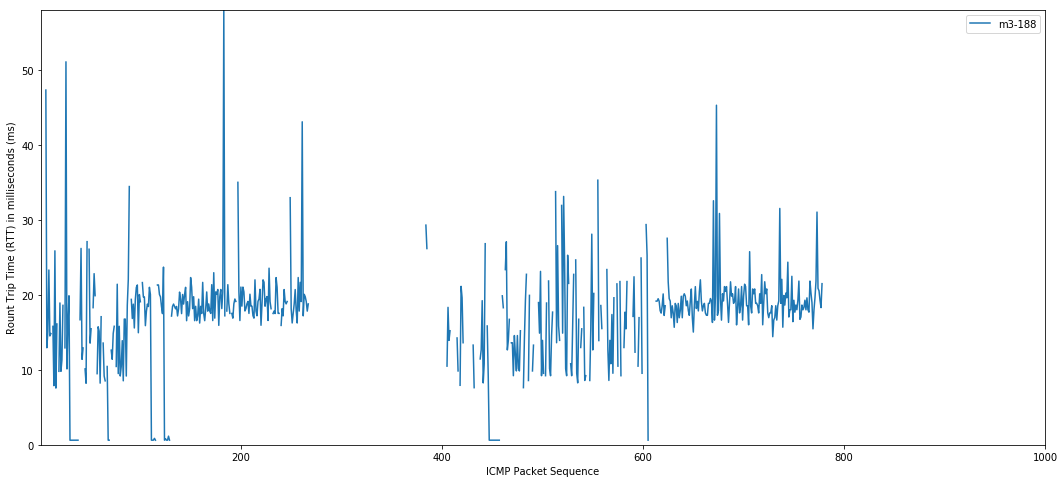

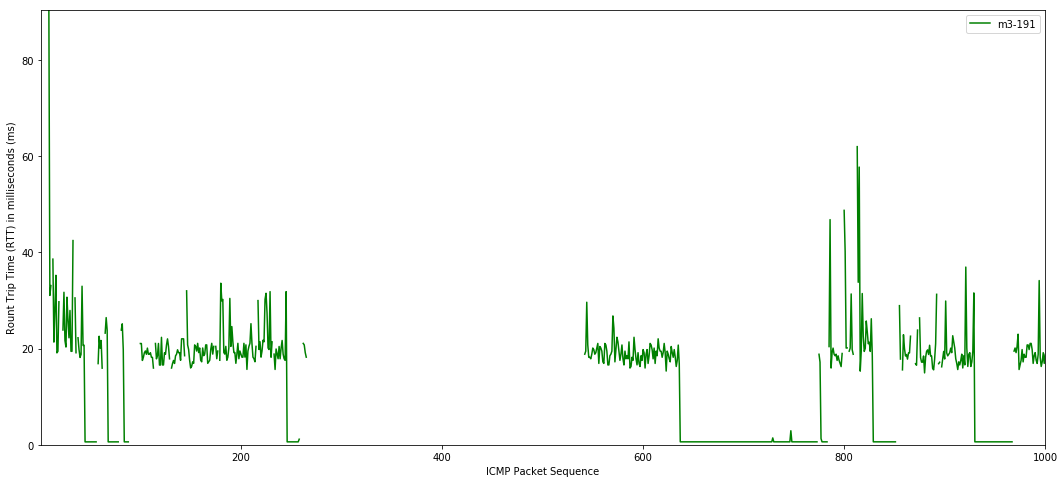

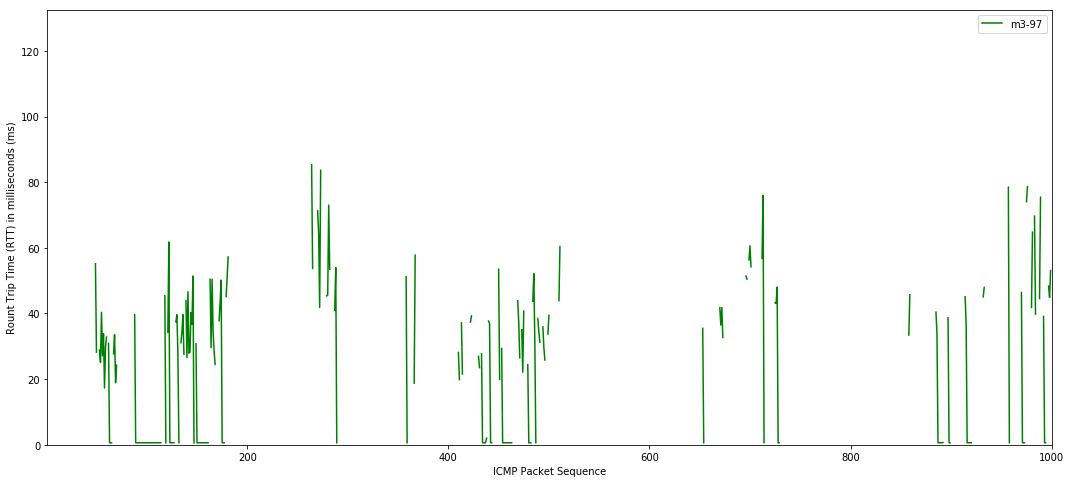

In [532]:
for node in nodes.keys():
    tms = nodes[node]
    
    plt.figure(figsize=(18,8))
    plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
    plt.xlabel('ICMP Packet Sequence')
    
    if node in hops[1]:
        plt.plot(icmp, tms, label=node)
    elif node in hops[2]:
        plt.plot(icmp, tms, 'green', label=node)
    else:
        plt.plot(icmp, tms, 'red', label=node)

    plt.axis([1,icmp[-1], 0.0, tms.max()])
    plt.legend()
    plt.show()

Let us see how does the delay change with respect to the distance from the root.

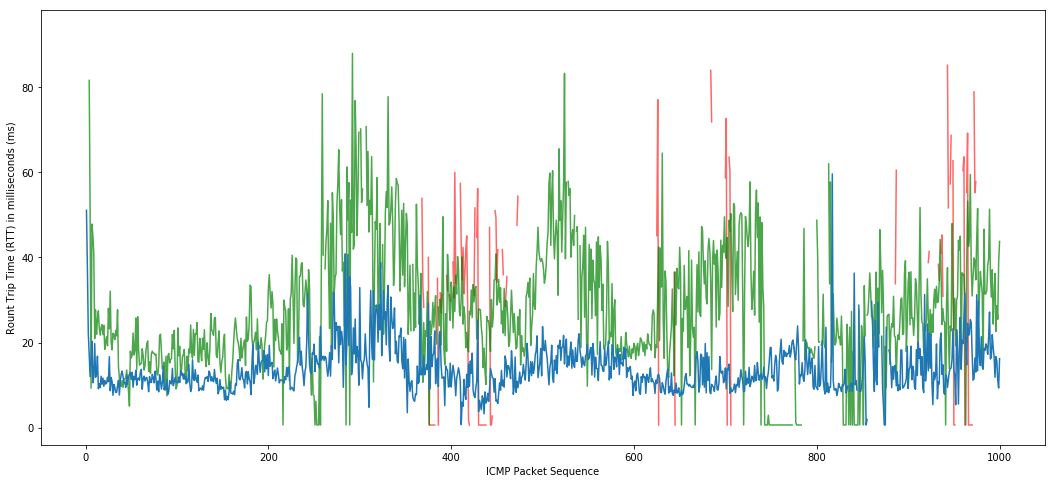

In [533]:
fig, ax = plt.subplots(figsize=(18,8))

line3, = ax.plot(icmp, hop_nodes[3], 'red', alpha=0.6, label='Hop 3')
line2, = ax.plot(icmp, hop_nodes[2], 'green', alpha=0.7, label='Hop 2')
line1, = ax.plot(icmp, hop_nodes[1], label='Hop 1')

plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')

plt.show()

It is also interesting to see how the time to complete 2000 pings varies as the distance from the root increases.

In [536]:
time_nodes = {}
for h in hops:
    for time in hop_nodes[h].keys():
        if h not in time_nodes:
            if np.isnan(hop_nodes[h][time]):
                time_nodes[h] = [None]
            else:
                time_nodes[h] = [hop_nodes[h][time]]
        else:
            
            if np.isnan(hop_nodes[h][time]):
                time_nodes[h].append(None)    
            elif len(list(filter(None, time_nodes[h]))) == 0:
                # time_nodes[h] contains only None values
                time_nodes[h].append(hop_nodes[h][time])
            else:
                time_nodes[h].append(max(filter(None, time_nodes[h])) + hop_nodes[h][time])

time_nodes = pd.DataFrame(time_nodes)
time_nodes.tail(1)

,2,1,3
999,26766.810864,13777.241649,NaN


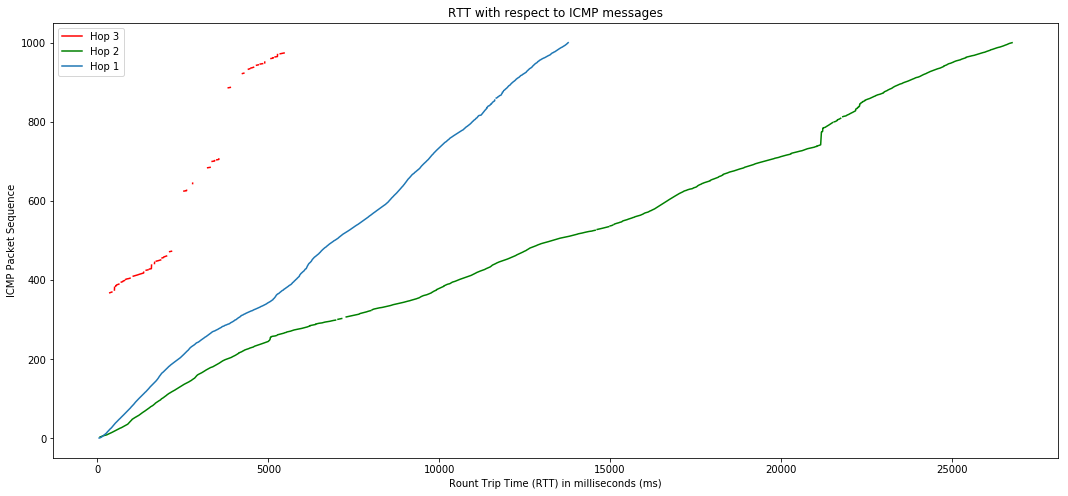

In [537]:
fig, ax = plt.subplots(figsize=(18,8))

line3, = ax.plot(time_nodes[3], icmp, 'red', label='Hop 3')
line2, = ax.plot(time_nodes[2], icmp, 'green', label='Hop 2')
line1, = ax.plot(time_nodes[1], icmp, label='Hop 1')

plt.ylabel('ICMP Packet Sequence')
plt.xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.title('RTT with respect to ICMP messages')
ax.legend()
plt.show()

## Statistics

It is also useful to read some statistics from the dataset. For each node:

In [538]:
nodes.describe()

,m3-102,m3-105,m3-110,m3-113,m3-118,m3-121,m3-126,m3-129,m3-134,m3-137,...,m3-161,m3-166,m3-169,m3-174,m3-179,m3-182,m3-185,m3-188,m3-191,m3-97
count,146.000000,337.000000,150.000000,331.000000,280.000000,222.000000,242.000000,180.000000,324.000000,356.000000,...,717.000000,421.000000,750.000000,797.000000,520.000000,693.000000,501.000000,545.000000,669.000000,281.000000
mean,40.648856,26.626659,37.742773,28.495459,25.407775,29.473977,26.649087,32.880333,25.645170,33.071469,...,14.019054,15.880494,17.923424,8.168016,5.945342,8.361385,13.607006,17.182202,13.313807,27.915270
std,27.489136,21.778591,24.072587,22.308389,20.481679,19.202897,23.774520,20.354233,21.121406,17.046519,...,7.976811,10.529272,11.709606,6.412957,5.828592,6.226080,11.579310,6.839463,10.891391,23.788349
min,0.604000,0.604000,0.604000,0.611000,0.604000,0.619000,0.605000,0.608000,0.605000,0.604000,...,0.630000,0.227000,0.604000,0.604000,0.604000,0.621000,0.603000,0.611000,0.604000,0.607000
25%,28.111250,0.629000,28.704500,0.634000,0.633000,20.074000,0.612000,21.342250,0.618000,21.573250,...,9.244000,9.202000,10.065250,0.704000,0.639000,7.523000,0.618000,15.229000,0.616000,0.617000
50%,42.462000,27.427000,40.991000,28.690000,27.129500,28.098500,24.159000,30.302000,25.620500,27.196500,...,10.445000,13.561000,18.419500,9.148000,7.857000,9.183000,12.247000,18.176000,17.571000,30.899000
75%,58.832000,41.678000,55.100000,41.553500,37.928250,38.922250,38.400000,43.350500,38.144750,41.642500,...,17.768000,21.466000,21.301750,10.131000,9.782000,10.145000,22.687000,19.953000,19.790000,43.899000
max,113.806000,91.857000,93.527000,103.777000,82.594000,83.256000,116.518000,116.036000,112.259000,100.435000,...,66.946000,67.356000,81.747000,50.616000,46.306000,64.229000,60.669000,58.072000,90.391000,132.473000


For each hop:

In [539]:
hop_nodes.describe()

,1,2,3
count,991.000000,979.000000,150.000000
mean,13.902363,27.340971,37.742773
std,5.756624,14.586685,24.072587
min,0.622000,0.615500,0.604000
25%,10.250500,18.389222,28.704500
50%,12.535500,25.253000,40.991000
75%,16.372208,36.206200,55.100000
max,59.631000,87.964333,93.527000


Intuitively we do expect the probability of error to increase as the number of Hops increase as well. Let's check:

In [540]:
pd.DataFrame([[h, str((len(hop_nodes[h]) - hop_nodes[h].count())/len(hop_nodes[h])*100) +'%'] for h in hops], \
             columns=['Hop','Probability of Error'])

,Hop,Probability of Error
0,2,2.1%
1,1,0.9%
2,3,85.0%


Let's try to see the statistical distribution of this data. We use a kernel density estimation (a way to estimate the probability density function of a random variable in a non-parametric way) and histograms. We can even anaylise "standard values" (i.e. values in range mean - 2std <= RTT <= mean + 2std) apart from outliers.

In [541]:
std_values = pd.DataFrame(columns=[1,2,3])  # Maintain x(t) if mean-2*std <= x(t) <? mean+2*std
outliers = pd.DataFrame(columns=[1,2,3])    # Maintain x(t) otherwise

for h in hops:
    # Returns two DataFrames containing standard values and outliers
    mn = hop_nodes[h].mean()
    std =hop_nodes[h].std()
    std_window = pd.Series([])  # Standard values
    out_window = pd.Series([])  # Outliers

    for window in (hop_nodes[h].groupby(hop_nodes[h].index // 10 * 10)):
        std_curr = []
        out_curr = []
        for x in window[1]:
            if mn-2*std <= x and x <= mn+2*std:
                std_curr.append(x)
                out_curr.append(None)
            else:
                std_curr.append(None)
                out_curr.append(x)
        
        std_window = std_window.append(pd.Series(std_curr))
        out_window = out_window.append(pd.Series(out_curr))
    
    std_values[h] = std_window
    outliers[h] = out_window

std_values = std_values.reset_index().drop(columns=['index'])
std_values.fillna(value=pd.np.nan, inplace=True)
outliers = outliers.reset_index().drop(columns=['index'])
outliers.fillna(value=pd.np.nan, inplace=True)

Let's start with the whole dataset.

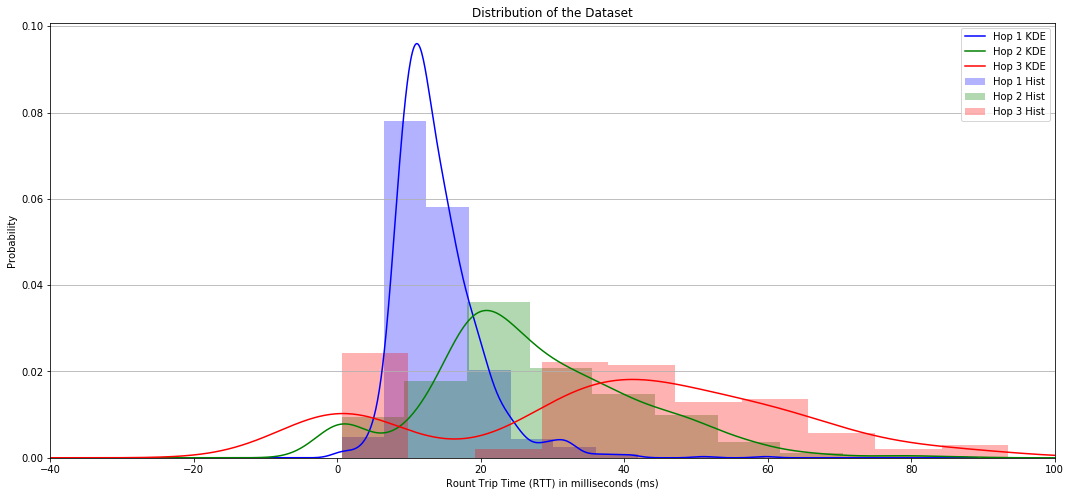

In [542]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in hop_nodes:
    
    if hop == 1:
        hop_nodes[hop].plot.kde(ax=ax,color='blue', title='Hop ' + str(hop), label='Hop 1 KDE')
        hop_nodes[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        hop_nodes[hop].plot.kde(ax=ax,color='green', title='Hop ' + str(hop), label='Hop 2 KDE')
        hop_nodes[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        hop_nodes[hop].plot.kde(ax=ax,color='red', title='Hop ' + str(hop), label='Hop 3 KDE')
        hop_nodes[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.grid(axis='y')
ax.set_title('Distribution of the Dataset')
ax.set_xlim([-40,100])
ax.legend()
plt.show()

Now we plot all values RTT excluding outliers (values in the range mean - 2std <= RTT <= mean + 2std).

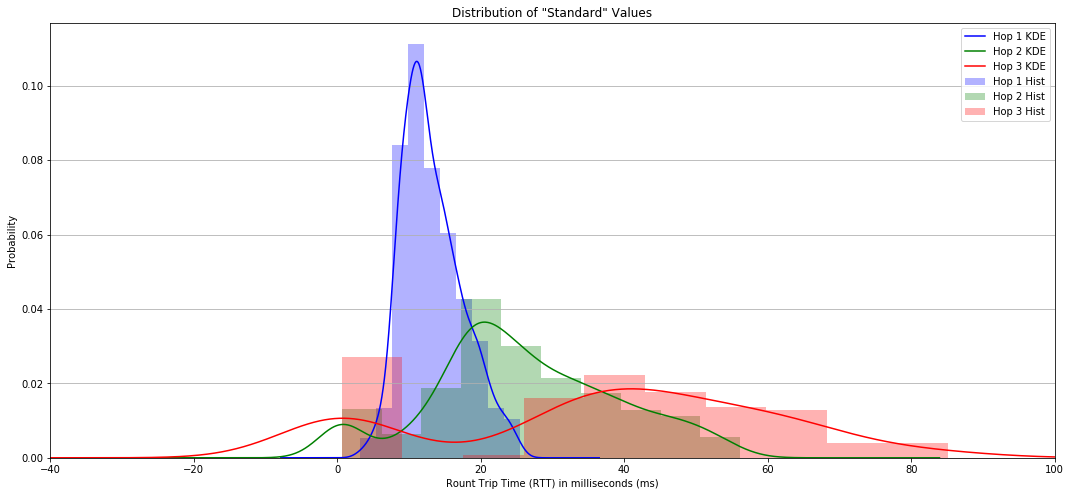

In [543]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in std_values:
    
    if hop == 1:
        std_values[hop].plot.kde(ax=ax,color='blue', label='Hop 1 KDE')
        std_values[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        std_values[hop].plot.kde(ax=ax,color='green', label='Hop 2 KDE')
        std_values[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        std_values[hop].plot.kde(ax=ax,color='red', label='Hop 3 KDE')
        std_values[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.set_title('Distribution of "Standard" Values')
ax.grid(axis='y')
ax.legend()
ax.set_xlim([-40,100])
plt.show()

And finally the distribution of outliers.

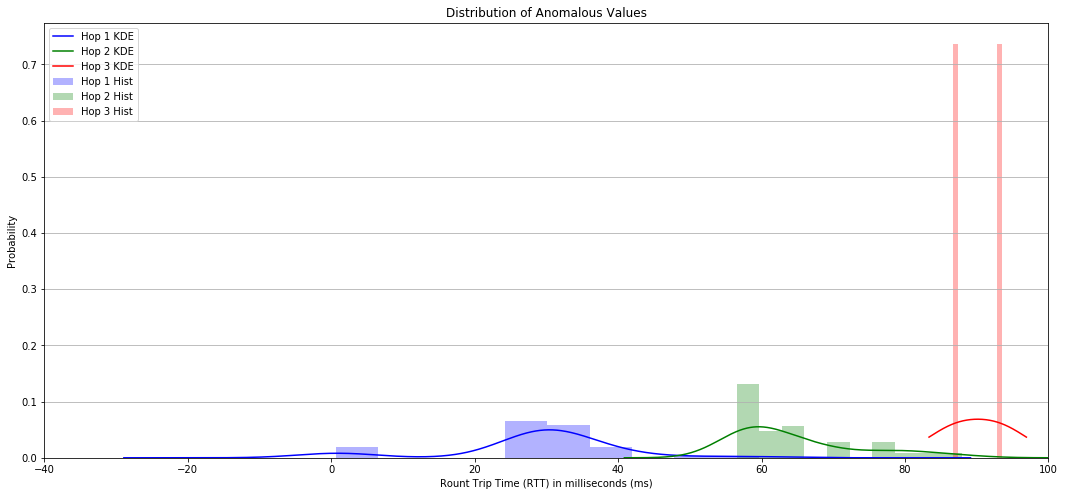

In [544]:
fig, ax = plt.subplots(figsize=(18,8))
for hop in outliers:
    
    if hop == 1:
        outliers[hop].plot.kde(ax=ax,color='blue', label='Hop 1 KDE')
        outliers[hop].plot.hist(density=True,color='blue',alpha=0.3, ax=ax, label='Hop 1 Hist')
    elif hop == 2:
        outliers[hop].plot.kde(ax=ax,color='green', label='Hop 2 KDE')
        outliers[hop].plot.hist(density=True,color='green',alpha=0.3, ax=ax, label='Hop 2 Hist')
    else:
        outliers[hop].plot.kde(ax=ax,color='red', label='Hop 3 KDE')
        outliers[hop].plot.hist(density=True,color='red',alpha=0.3, ax=ax, label='Hop 3 Hist')
        
ax.set_ylabel('Probability')
ax.set_xlabel('Rount Trip Time (RTT) in milliseconds (ms)')
ax.grid(axis='y')
ax.set_title('Distribution of Anomalous Values')
ax.legend()
ax.set_xlim([-40,100])
plt.show()

# Tumbling Windows

Now we analyse the dataset using tumbling windows of size 10. This could help us to find other relations inside the data.

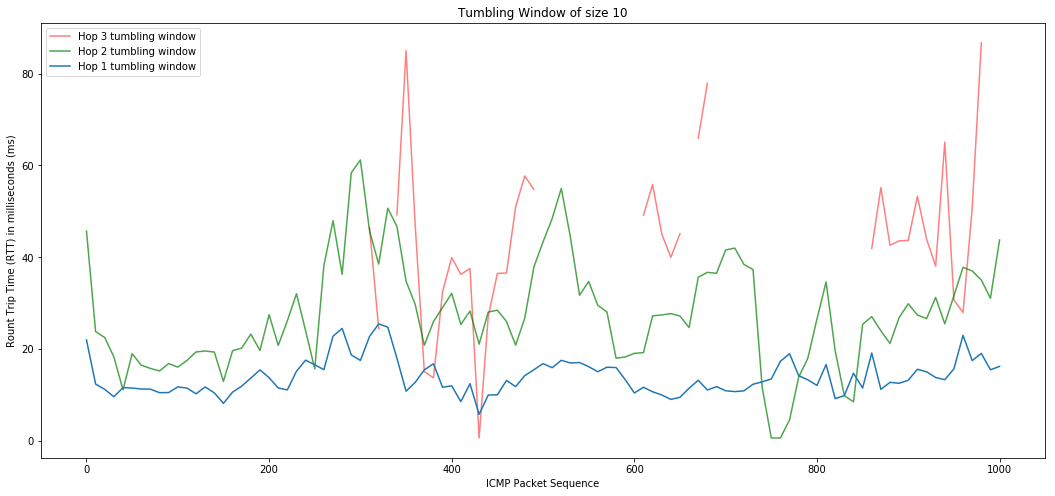

In [545]:
plt.figure(figsize=(18,8))
plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')
plt.plot(hop_nodes[3].groupby(hop_nodes[3].index // 10 * 10).mean(), 'red', alpha=0.5, label='Hop 3 tumbling window')
plt.plot(hop_nodes[2].groupby(hop_nodes[2].index // 10 * 10).mean(), 'green', alpha=0.7, label='Hop 2 tumbling window')
plt.plot(hop_nodes[1].groupby(hop_nodes[1].index // 10 * 10).mean(), label='Hop 1 tumbling window')
plt.title('Tumbling Window of size 10')
plt.legend()

Let us try to exclude outliers from this plot.

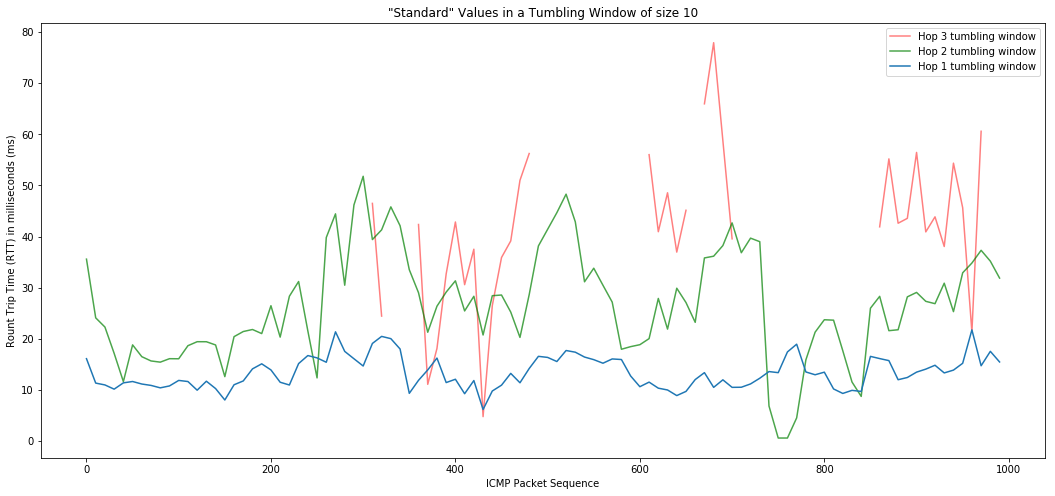

In [546]:
plt.figure(figsize=(18,8))
plt.ylabel('Rount Trip Time (RTT) in milliseconds (ms)')
plt.xlabel('ICMP Packet Sequence')
plt.plot(std_values[3].groupby(std_values[3].index // 10 * 10).mean(), 'red', alpha=0.5, label='Hop 3 tumbling window')
plt.plot(std_values[2].groupby(std_values[2].index // 10 * 10).mean(), 'green', alpha=0.7, label='Hop 2 tumbling window')
plt.plot(std_values[1].groupby(std_values[1].index // 10 * 10).mean(), label='Hop 1 tumbling window')
plt.title('"Standard" Values in a Tumbling Window of size 10')
plt.legend()

It will be useful to compare ping timeouts and outliers to check if there is some relation between those two.

In [547]:
lost = pd.DataFrame()  # Maintain x(t) if mean-2*std <= x(t) <? mean+2*std
for h in hop_nodes:
    loss_p = []
    
    for p in hop_nodes[h]:
        if not np.isnan(p):
            loss_p.append(np.nan)
        else:
            loss_p.append(-100)
    
    lost[h] = pd.Series(loss_p)
    
lost.head(10)

,1,2,3
0,NaN,-100.0,-100.0
1,NaN,-100.0,-100.0
2,NaN,-100.0,-100.0
3,NaN,NaN,-100.0
4,NaN,NaN,-100.0
5,NaN,NaN,-100.0
6,NaN,NaN,-100.0
7,NaN,NaN,-100.0
8,NaN,NaN,-100.0
9,NaN,NaN,-100.0


For each hop, we plot one dimensional points that represent outliers and ping timeouts.

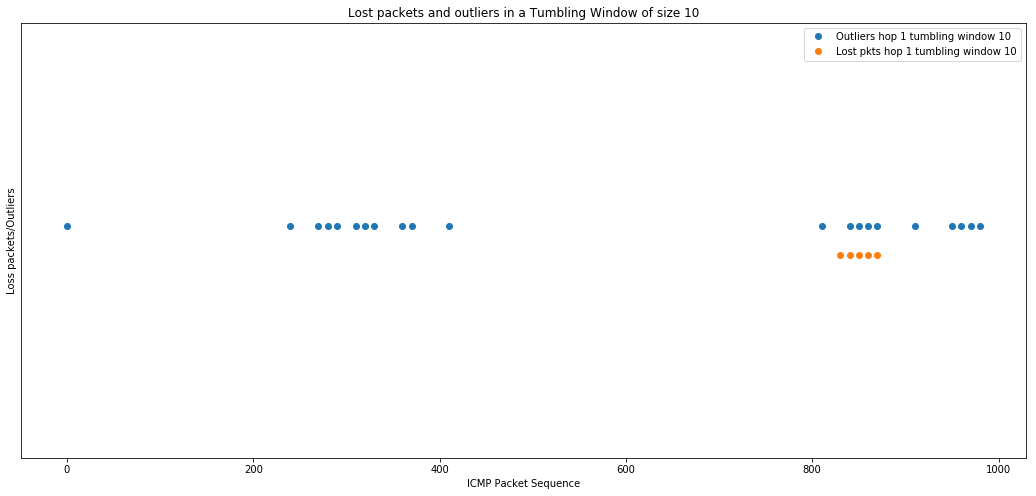

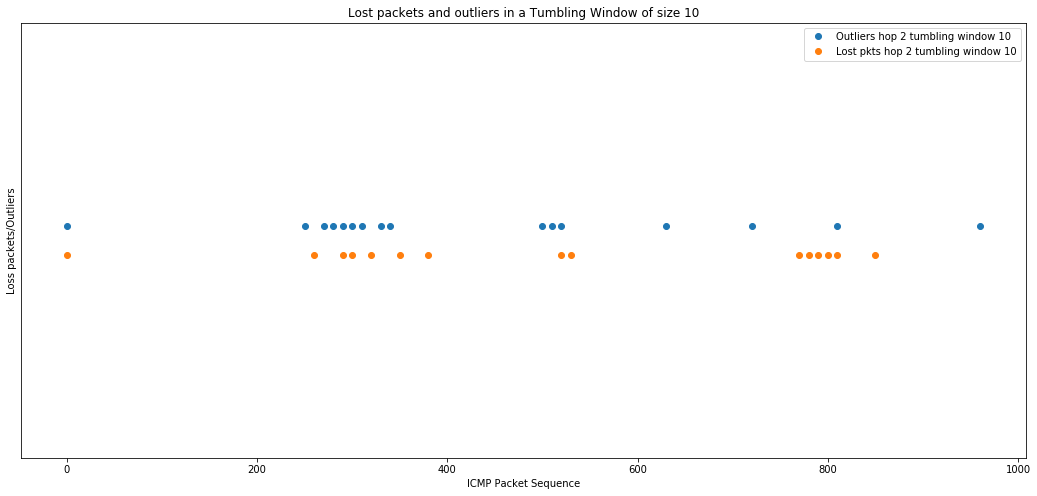

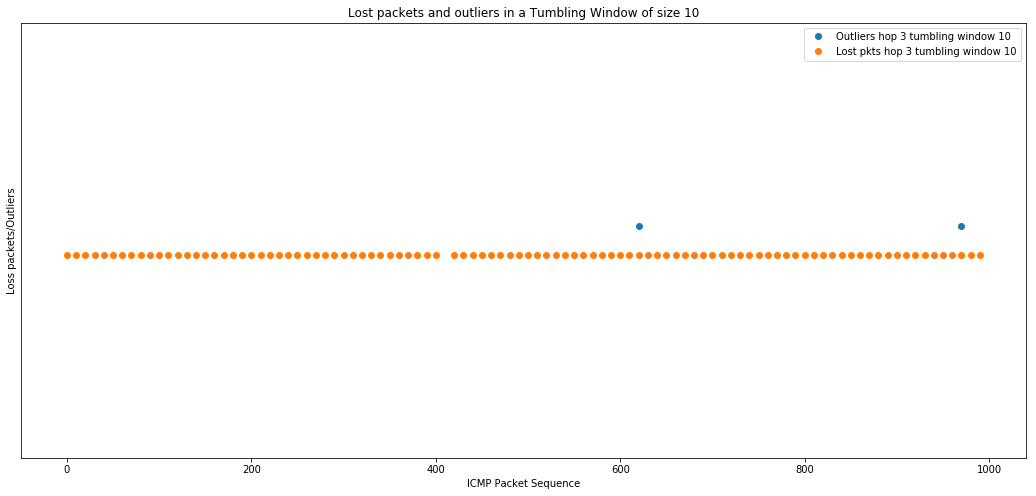

In [548]:
for h in hop_nodes:
    plt.figure(figsize=(18,8))
    plt.ylabel('Loss packets/Outliers')
    plt.xlabel('ICMP Packet Sequence')

    plt.plot(outliers[h].groupby(outliers[h].index // 10 * 10).mean().dropna().index, [1 for x in outliers[h].groupby(outliers[h].index // 10 * 10).mean().dropna().index], 'o', label='Outliers hop '+str(h)+' tumbling window 10')
    plt.plot(lost[h].groupby(lost[h].index // 10 * 10).mean().dropna().index, [-1 for x in lost[h].groupby(lost[h].index // 10 * 10).mean().dropna().index], 'o', label='Lost pkts hop '+str(h)+' tumbling window 10')
    
    plt.title('Lost packets and outliers in a Tumbling Window of size 10')
    plt.ylim([-15,15])
    plt.yticks([])
    plt.legend()

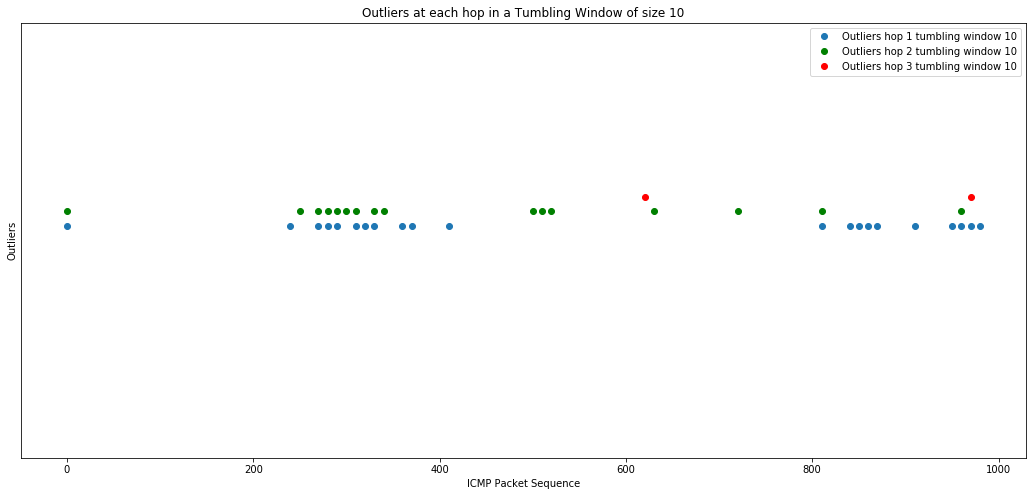

In [549]:
plt.figure(figsize=(18,8))
plt.ylabel('Outliers')
plt.xlabel('ICMP Packet Sequence')
for h in hop_nodes:
    if h == 2:
        plt.plot(outliers[h].groupby(outliers[h].index // 10 * 10).mean().dropna().index, [h for x in outliers[h].groupby(outliers[h].index // 10 * 10).mean().dropna().index], 'o', color='green', label='Outliers hop '+str(h)+' tumbling window 10')
    elif h == 3:
        plt.plot(outliers[h].groupby(outliers[1].index // 10 * 10).mean().dropna().index, [h for x in outliers[h].groupby(outliers[1].index // 10 * 10).mean().dropna().index], 'o', color='red', label='Outliers hop '+str(h)+' tumbling window 10')
    else: 
        plt.plot(outliers[h].groupby(outliers[1].index // 10 * 10).mean().dropna().index, [h for x in outliers[h].groupby(outliers[1].index // 10 * 10).mean().dropna().index], 'o', label='Outliers hop '+str(h)+' tumbling window 10')
    
    
plt.title('Outliers at each hop in a Tumbling Window of size 10')
plt.ylim([-15,15])
plt.yticks([])
plt.legend()